# Surveillance-Detection Application
## Object Detection with Live CCTV Footage

This project aims to implement object detection on live CCTV footage using open-source vision models. The initial plan is to:

1. **Set up the environment**: Install necessary libraries and dependencies for object detection, such as OpenCV and popular deep learning frameworks (e.g., TensorFlow, PyTorch).
2. **Integrate live video stream**: Capture live footage from CCTV cameras using OpenCV.
3. **Test open-source models**: Evaluate pre-trained object detection models (e.g., YOLO, SSD, Faster R-CNN) on the video feed.
4. **Perform object detection**: Identify and classify objects in real-time from the video stream.
5. **Evaluate model performance**: Measure the detection accuracy and latency of each model on live footage.

This notebook will focus on experimenting with different object detection models to assess their effectiveness in real-time applications.


## Importing necessary packages

In [15]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import urllib

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False)

from PIL import Image
import requests
from IPython.display import display, clear_output

## DETR with ResNet-50 for Object Detection

**DETR (Detection Transformers)** is an object detection model that uses a Transformer architecture to predict objects directly, without relying on anchors or post-processing like non-maximum suppression.

- **ResNet-50 Backbone**: Extracts feature maps from images, providing rich semantic information.
- **Transformer Encoder-Decoder**: The encoder captures global dependencies, and the decoder predicts object locations and classes.

**Advantages:**
- **End-to-end training**: Simplifies the detection pipeline.
- **Global context understanding**: Handles long-range dependencies well.

DETR with ResNet-50 offers an efficient, accurate solution for real-time object detection tasks like CCTV footage analysis.


In [6]:
%%time
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

Using cache found in C:\Users\asuto/.cache\torch\hub\facebookresearch_detr_main


CPU times: total: 3.91 s
Wall time: 1.45 s


In [28]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [8]:
# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    # T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
# Function for output bounding box post-processing. xCenter,yCenter,width,height format to xMin,yMin,xMax,yMax format.
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),(x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

In [11]:
# Function to rescale prediction bounding boxes to original size of the image.
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [13]:
# Function to plot bounding boxes, label and probability on the original image.
def plot_frame(frame, prob, boxes):
    colors = COLORS * 100
    for p,(xmin,ymin,xmax,ymax),c in zip(prob,boxes.tolist(),colors):
        [xmin, ymin, xmax, ymax] = [int(i) for i in [xmin, ymin, xmax, ymax]]
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        c = [255,0,0]
        frame = cv.rectangle(frame, (xmin,ymin), (xmax,ymax),thickness=2,color=c)
        frame = cv.putText(frame,text,(xmin,ymin-5),cv.FONT_HERSHEY_SIMPLEX,fontScale = 0.8,color=c,thickness = 2)
    return frame
        

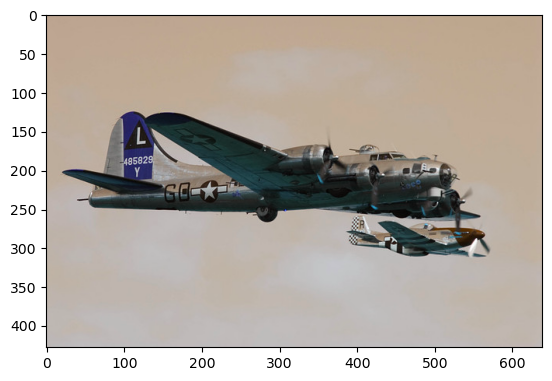

In [35]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url = 'https://farm6.staticflickr.com/5004/5216021428_d8f3a681f0_z.jpg'
# url = 'https://farm8.staticflickr.com/7164/6496450217_58c35db160_z.jpg'
# url = 'http://images.cocodataset.org/test-stuff2017/000000006149.jpg'

req = urllib.request.urlopen(url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img_orig = cv.imdecode(arr, -1) 

plt.imshow(img_orig)
plt.show()

### Testing DETR ResNet50

In [36]:
%%time
img = transform(img_orig).unsqueeze(0)
outputs = model(img)

CPU times: total: 2.77 s
Wall time: 448 ms


In [37]:
%%time
# Keeping predictions with probability above threshold %
probThresh = 0.7

probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > probThresh

CPU times: total: 0 ns
Wall time: 1 ms


In [38]:
# BBox Creation
bboxes_scaled_img = rescale_bboxes(outputs['pred_boxes'][0, keep], img_orig.shape[:-1][::-1])

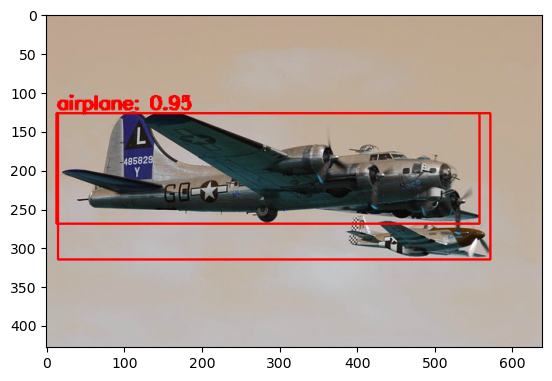

In [39]:
img_pred = plot_frame(img_orig,probas[keep],bboxes_scaled_img)
plt.imshow(img_pred)
plt.show()